# Predicting Nerdiness level <a class="anchor" id="1"></a> 

Nerd is a common social label in English, although there is no set list of criteria. The objective of this project is to predict **`How Nerdy a person think they can be ?`** on a Nerdiness scale of **`0-7`** using the [Nerdy Personality Attributes Scale data](https://openpsychometrics.org/_rawdata/). The NPAS was developed by surveying a very large pool of personality attributes to see which ones correlated with self reported nerd status, and combining them all into a scale. The dataset is sourced from the Open-Source Psychometrics Project at https://openpsychometrics.org/_rawdata/ <cite data-cite="Development of the Nerdy Personality Attributes Scale">(Anonymous, 2015)</cite>. 

This report is organized as follows:
- [Section 2 (Overview)](#2) outlines our methodology. 
- [Section 3 (Data Preparation)](#3) summarizes the data preparation process and our model evaluation strategy. 
- [Section 4 (Feature Selection)](#4) describes the feature selection and ranking algorithms. 
- [Section 5 (Model Evaluation Strategy)](#5) approach we took for Model evaluation.
- [Section 6 (Hyperparameter Tuning)](#6) describes the hyperparameter tuning process for each classification algorithm.
- [Section 7 (Other Algorithms)](#7) other algorithms tried(Bonus).
- [Section 8 (Performance Comparison)](#8) presents model performance comparison results.
- [Section 9 (Limitations)](#9) discusses a limitations of our approach and possible solutions. 
- [Section 10 (Conclusion)](#10) provides a brief summary of our work in this project.


# Overview <a class="anchor" id="2"></a> 

### Methodology

We build the following multi level classifiers to predict the target feature:

* K-Nearest Neighbors (KNN),
* Random Forest,
* Multi nomial Naive Bayes (NB),
* Gower Classifier,
* CatBoost 


Our modeling strategy begins by using the cleaned dataset from Phase I. We then transformed our data by converting the categorical descriptive features into numeric using one-hot encoding followed by scaling of the descriptive features. Considering our dataset had 25k + rows after cleaning we did not do sampling and used the dataset as it is for splitting them into train and test and we used 70:30 split ratio. After split our training data has 17595 rows and test data has 7541 rows. 
After one-hot encoding we had a total of 339 descriptive features. We use two Feature selection and Ranking Algorithms which are mentioned in the above section. As next step, we performed a regressive Hyper parameter tuning where we use all the descriptive features and another hypertuned model using selected features from the ranking algorithm above. We also include a GridSearch 5-fold stratified cross validation fur the regressive hyper paramter tuning process. 

Considering our target labels had unbalanced levels it was important for us to perform statification while hypertuning and then examing each model's accuracy. Two best models are chosen for each algorithms performed on training data and we use the same 5-fold stratified cross valudation to validate the chosen candidate models on the test data. We pick the best one among each category and perform a pairwise t-test to see if there are any statistically significant differences. 

Finally, we compare these models in the form of classififcation reports and confusion matrices. 

# Data Preparation <a class="anchor" id="3"></a> 

## Loading the cleaned dataset

Phase 1 of the project involved data cleaning and preprocessing and we saved the cleaned dataset into a pickle file for ease of use in the Phase 2. We load the pickled files and start with the modelling tasks outlined in the above section. 

It was important for us to save as pickle object rather than csv as we have converted the data types to categorical and it has to be preserved for further modelling part in this phase, which was not the case when saving them to csv. 

In [10]:
import warnings
warnings.filterwarnings("ignore")

import io
import pickle
import os as os
import requests 
import numpy as np
import pandas as pd 

from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale
from pandas.api.types import CategoricalDtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import MultinomialNB


pd.set_option('display.max_columns', 80) #set options to display all the columns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# set seed for reproducibility of results
seed = 999

In [11]:
# Reading the cleaned data file from phase 1
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

In [12]:
# Reading in the columns list saved for further use with numpy.array
with open('data.ohcolumns.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    colList = pickle.load(f)

In [13]:
# Reading in the list of important features selected list from rF and SPFSA algorithms - to be used in hyoer tuning
with open('data.impFeatures', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    impFeatures = pickle.load(f)

In [14]:
data.shape #validating the rows and columns count

(25197, 79)

In [15]:
# validating the preservance of the dtypes converted
print(f"Count of data Types are: ")
data.dtypes.value_counts(sort=True)

Count of data Types are: 


category    26
category    24
category    11
int64        7
category     4
category     3
category     1
category     1
object       1
category     1
dtype: int64

Upon confirming the data type conversion is preserved in the pickled file, we perform some data handling and processing which includes Feature Engineering, converting the categorical descriptive features into numerical using one-hot encoding and scaling the features. 

## Feature Engineering

Upon further analysis we considered creating a new feature called **`screenArea`** by aggregating two of the existing features **`screenw * screenh`** (screen width x screen height). 

In [16]:
data['screenArea'] = data['screenw'] * data['screenh']

In [17]:
data['screenArea'].quantile([.01,.25,.5,.75,.99])

0.01    170880.00
0.25    250125.00
0.50   1049088.00
0.75   1296000.00
0.99   2559600.00
Name: screenArea, dtype: float64

From above **quantile result**, we can see that the newly created feature **ScreenArea** has some extreme values which is because of the formula and the screen sizes are given in pixels which is the main reason for seeing such high values. However we will be scaling the features and hence can decide the further use of this feature based on the analysis we will be performing. 

Also, upon initial correlation check from Phase 1 we found that TIPI features has very high correlation when we do one hot encoding, hence excluding the values that are all zero for all TIPI features to avoid multi collinearity effect

In [18]:
data = data[~(data.loc[:,'TIPI1':'TIPI10':1]==0).all(axis=1)] 

In [19]:
data.shape

(25136, 80)

In [20]:
for d in data.columns:
    if(data[d].isna().sum() > 0):
        print(f"{d} {str(data[d].isnull().sum())}")
del d

country 3


We have the new feature created and validated for any NA's in the dataset. Now we have to drop the screenw and screenh features from the dataset. Also upon further reading about the dataset information we decided to exclude the **`country`** feature as well. This approach is backed by the intuitive and domain information that the country feature was captured by the system function based on the locaition where the user took the personality survey. 

Instead of dropping them from the original dataset, we will drop them in the below step where we exclude the target feature from the full dataset

In [21]:
# drop the nerdy, screenw and screenh features from the dataset along with the country variable from the full dataset
Data = data.drop(columns=['nerdy','screenw', 'screenh', 'country'])
target = data['nerdy']

In [22]:
Data.shape
target.value_counts()
target.dtype

(25136, 76)

6    7552
7    6588
5    5927
4    3040
3     846
2     649
1     494
0      40
Name: nerdy, dtype: int64

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7], ordered=True)

We observe that the target feature levels are not quiet balanced, we might have to consdider starifying approach while doing train test split

In [23]:
Data.describe(include='category')

Q1     Q2     Q3     Q4     Q5     Q6     Q7     Q8     Q9    Q10  \
count   25136  25136  25136  25136  25136  25136  25136  25136  25136  25136   
unique      6      6      6      6      6      6      6      6      6      6   
top         5      5      5      5      5      4      5      5      5      5   
freq     9959  12225  12863   9277   9483   8133  12829  11170   9568  11719   

          Q11    Q12    Q13    Q14    Q15    Q16    Q17    Q18    Q19    Q20  \
count   25136  25136  25136  25136  25136  25136  25136  25136  25136  25136   
unique      6      6      6      6      6      6      6      6      6      6   
top         5      5      5      5      1      5      5      5      5      5   
freq     7212   9125   9965   8183   6257   8166  10359  11753   9200   7818   

          Q21    Q22    Q23    Q24    Q25    Q26  TIPI1  TIPI2  TIPI3  TIPI4  \
count   25136  25136  25136  25136  25136  25136  25136  25136  25136  25136   
unique      6      6      6      6      6      6      8      8      8      8   
top         1      1      5      5      4      5      2      5      6      5   
freq     7748   8881  11432  13150   6424  12323   5791   6923   6686   5837   

        TIPI5  TIPI6  TIPI7  TIPI8  TIPI9  TIPI10   VCL1   VCL2   VCL3   VCL4  \
count   25136  25136  25136  25136  25136   25136  25136  25136  25136  25136   
unique      8      8      8      8      8       8      2      2      2      2   
top         6      7      6      5      6       1      1      1      1      1   
freq     7797   7466   6375   5998   4924    8523  24190  23266  13360  24393   

         VCL5   VCL6   VCL7   VCL8   VCL9  VCL10  VCL11  VCL12  VCL13  VCL14  \
count   25136  25136  25136  25136  25136  25136  25136  25136  25136  25136   
unique      2      2      2      2      2      2      2      2      2      2   
top         1      0      0      0      0      1      0      0      1      1   
freq    23882  22519  19150  14027  23399  24082  18043  19778  19197  22810   

        VCL15  VCL16  education  urban  gender  engnat   hand  religion  \
count   25136  25136      25136  25136   25136   25136  25136     25136   
unique      2      2          5      4       4       3      4        13   
top         1      1          2      2       2       1      1         2   
freq    24169  24690      10392  11487   15162   16506  21433      7325   

        orientation  voted  married  race_arab  race_asian  race_black  \
count         25136  25136    25136      25136       25136       25136   
unique            6      3        4          2           2           2   
top               1      2        1          0           0           0   
freq          14049  15872    21474      24629       21285       23947   

        race_white  race_hispanic  race_nativeam  race_nativeau  race_other  \
count        25136          25136          25136          25136       25136   
unique           2              2              2              2           2   
top              1              0              0              0           0   
freq         19001          22664          24228          25063       23299   

          ASD  
count   25136  
unique      3  
top         2  
freq    23422

In [24]:
Data.describe(include = np.number)

introelapse  testelapse  surveyelapse      age  familysize  screenArea
count     25136.00    25136.00      25136.00 25136.00    25136.00    25136.00
mean        114.22      127.05        185.29    23.99        2.48   977521.48
std         338.22       92.98         96.21    10.76        1.34   674819.07
min           0.00       23.00          2.00    13.00        0.00    17024.00
25%           4.00       82.00        127.00    17.00        2.00   250125.00
50%          10.00      105.00        164.00    20.00        2.00  1049088.00
75%          33.00      138.00        213.00    27.00        3.00  1296000.00
max        2992.00     1143.00       1022.00   116.00       23.00  8294400.00

## Encoding Categorical Features

As stated in our modelling approach we will do one-hot encoding to convert the categorical features into numerical features. Our datset has a mix of ordered and nominal categorical variables. For nominal it is necessary to perform a one-hot encoding, however it was not the same case for the ordered type. But as we stated in our Phase 1 report that we are trying to classify how nerdy as person can be and we are not quantifying. Considering that we wanted to give each level equal weightage and independence which will be deviated when we choose integer encoding over one-hot encoding. Hence it makes sence to go with one-hot encoding for all the categorical features regardless of them being nominal or ordinal.

In [25]:
# creating a list of category columns to be passed on as input to the one=-hot encoding function.
categorical_cols = Data.columns[~Data.columns.isin(['age','introelapse', 
                                              'testelapse', 'surveyelapse', 
                                              'screenArea', 
                                              'familysize'])].tolist()

In [26]:
print('The categorical features to be transformed are: ' '\n \n' + str(categorical_cols))

The categorical features to be transformed are: 
 
['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education', 'urban', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'race_arab', 'race_asian', 'race_black', 'race_white', 'race_hispanic', 'race_nativeam', 'race_nativeau', 'race_other', 'ASD']


In [27]:
#saving pickle object for ease of use at later stages during modelling if required
#saving the Data and target seperately

with open('data.orig.x', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Data, f, pickle.HIGHEST_PROTOCOL)

with open('data.orig.y', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(target, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# creating dummies for the whole data
Data = pd.get_dummies(Data)

In [29]:
#upon validation to be commented for noprint in the report
# print(Data.columns.values)

In [30]:
Data.sample(5, random_state=seed)

introelapse  testelapse  surveyelapse  age  familysize  screenArea  \
14743            5          81            91   19           3     2073600   
17129            2         142           239   19           3      181760   
3013           165          69           108   24           5     1296000   
5552             3         130           210   26           3      181760   
23645           11         213           287   25           2      230400   

       Q1_0  Q1_1  Q1_2  Q1_3  Q1_4  Q1_5  Q2_0  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  \
14743     0     0     0     0     1     0     0     0     0     0     1     0   
17129     0     0     0     0     1     0     0     0     0     1     0     0   
3013      0     0     0     1     0     0     0     0     0     0     0     1   
5552      0     0     0     1     0     0     0     0     0     0     0     1   
23645     0     1     0     0     0     0     0     0     0     0     1     0   

       Q3_0  Q3_1  Q3_2  Q3_3  Q3_4  Q3_5  Q4_0  Q4_1  Q4_2  Q4_3  Q4_4  Q4_5  \
14743     0     0     0     0     0     1     0     0     0     0     1     0   
17129     0     0     0     0     0     1     0     0     0     1     0     0   
3013      0     0     0     0     0     1     0     0     0     0     0     1   
5552      0     0     0     0     1     0     0     0     1     0     0     0   
23645     0     1     0     0     0     0     0     1     0     0     0     0   

       Q5_0  Q5_1  Q5_2  Q5_3  Q5_4  Q5_5  Q6_0  Q6_1  Q6_2  Q6_3  ...    \
14743     0     0     1     0     0     0     0     0     0     1  ...     
17129     0     1     0     0     0     0     0     0     1     0  ...     
3013      0     0     0     0     1     0     0     0     0     0  ...     
5552      0     0     0     1     0     0     0     0     0     0  ...     
23645     0     0     1     0     0     0     0     0     1     0  ...     

       religion_5  religion_6  religion_7  religion_8  religion_9  \
14743           0           0           0           0           0   
17129           0           0           1           0           0   
3013            1           0           0           0           0   
5552            0           0           0           0           0   
23645           0           1           0           0           0   

       religion_10  religion_11  religion_12  orientation_0  orientation_1  \
14743            0            0            0              0              1   
17129            0            0            0              0              1   
3013             0            0            0              0              1   
5552             0            0            0              0              0   
23645            0            0            0              0              1   

       orientation_2  orientation_3  orientation_4  orientation_5  voted_0  \
14743              0              0              0              0        0   
17129              0              0              0              0        0   
3013               0              0              0              0        0   
5552               1              0              0              0        0   
23645              0              0              0              0        0   

       voted_1  voted_2  married_0  married_1  married_2  married_3  \
14743        0        1          0          1          0          0   
17129        1        0          0          1          0          0   
3013         1        0          0          1          0          0   
5552         1        0          0          1          0          0   
23645        1        0          0          1          0          0   

       race_arab_0  race_arab_1  race_asian_0  race_asian_1  race_black_0  \
14743            1            0             1             0             1   
17129            1            0             1             0             1   
3013             1            0             1             0             1   
5552             1       

The below code is basically subsetting the original dataset with just the important features from the feature selection algorithms tried. The purpose of this is to save these to pickle object at this point and further use it to create scalled dataset using these selected features as numpy array does not have column list and we need this to etract the columns we needed. 

In [31]:
#Subsetting a dataframe with selected features
Data_sel = Data[impFeatures]

In [32]:
Data_sel.shape

(25136, 89)

In [33]:
Data_sel.sample(5, random_state = seed)

Q10_1  Q10_5  Q11_1  Q11_5  Q12_0  Q12_1  Q12_2  Q12_3  Q12_4  Q12_5  \
14743      0      1      0      0      0      0      0      0      0      1   
17129      0      1      1      0      0      0      0      0      1      0   
3013       0      1      1      0      0      0      0      0      1      0   
5552       0      1      1      0      0      0      1      0      0      0   
23645      0      0      1      0      0      0      0      0      1      0   

       Q13_4  Q13_5  Q14_2  Q14_5  Q15_1  Q15_5  Q16_5  Q17_5  Q18_5  Q19_0  \
14743      0      0      0      0      0      1      1      1      1      0   
17129      0      0      0      0      1      0      0      0      0      0   
3013       0      1      0      0      0      0      0      1      1      0   
5552       0      1      0      0      0      0      0      1      0      0   
23645      0      0      0      0      0      0      0      0      0      0   

       Q19_5  Q1_4  Q1_5  Q20_5  Q21_1  Q21_5  Q22_1  Q23_4  Q23_5  Q24_2  \
14743      1     1     0      0      0      0      1      0      0      0   
17129      0     1     0      1      1      0      1      0      0      1   
3013       0     0     0      0      0      0      0      0      1      0   
5552       0     0     0      0      1      0      0      0      1      0   
23645      0     0     0      0      1      0      1      0      0      0   

       Q24_3  Q24_5  Q26_1  Q26_5  Q2_4  Q2_5  Q3_5  Q4_0  Q4_3  Q4_5  \
14743      1      0      0      0     1     0     1     0     0     0   
17129      0      0      0      0     0     0     1     0     1     0   
3013       0      0      0      1     0     1     1     0     0     1   
5552       1      0      0      1     0     1     0     0     0     0   
23645      0      0      0      1     1     0     0     0     0     0   

        ...     TIPI10_1  TIPI10_2  TIPI10_3  TIPI1_2  TIPI1_3  TIPI2_4  \
14743   ...            0         0         1        1        0        0   
17129   ...            0         1         0        0        0        0   
3013    ...            0         0         0        1        0        0   
5552    ...            1         0         0        0        1        0   
23645   ...            1         0         0        0        0        0   

       TIPI2_5  TIPI5_1  TIPI5_4  TIPI5_5  TIPI5_6  TIPI5_7  TIPI6_2  TIPI9_2  \
14743        0        0        0        1        0        0        0        0   
17129        0        0        1        0        0        0        0        0   
3013         0        0        0        0        1        0        0        0   
5552         0        0        0        0        1        0        0        0   
23645        0        0        0        1        0        0        0        0   

       TIPI9_7  VCL1_1  VCL4_0  age  education_2  education_4  engnat_1  \
14743        0       1       0   19            1            0         1   
17129        0       0       0   19            1            0         1   
3013         0       1       0   24            0            0         1   
5552         0       1       0   26            0            0         0   
23645        0       1       0   25            0            0         1   

       engnat_2  familysize  gender_2  introelapse  married_1  orientation_1  \
14743         0           3         0            5          1              1   
17129         0           3         1            2          1              1   
3013          0           5         1          165          1              1   
5552          1           3         1            3          1              0   
23645         0           2         0           11          1              1   

       orientation_2  race_black_0  race_nativeau_0  religion_0  religion_2  \
14743              0             1                1           0           0   
17129              0             1                1           0           0   
3013               0             1              

Upon confirming that the subsetted dataset has only 89 features we proceed writing them to pickle file for ease of use in the later sections

In [34]:
# Writing the selected features dataset to a pickle object 
with open('Data_sel', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Data_sel, f, pickle.HIGHEST_PROTOCOL)

## Scaling of features

As the next approach we will use the MinMax scaler for the descriptive features, it does not impact the categorical features that were converted as it will be 0's and 1's after one hot encoding.

In [35]:
Data_df = Data.copy() # copying data to another df before we scale

In [36]:
# Scaling on the complete dataset
Data_scaler = preprocessing.MinMaxScaler()
print(Data_scaler)

Data_scaler.fit(Data)
Data = Data_scaler.fit_transform(Data)

MinMaxScaler(copy=True, feature_range=(0, 1))


MinMaxScaler(copy=True, feature_range=(0, 1))

In [37]:
pd.DataFrame(Data, columns=Data_df.columns).sample(5, random_state=seed)

introelapse  testelapse  surveyelapse  age  familysize  screenArea  \
14695         0.00        0.05          0.09 0.06        0.13        0.25   
17076         0.00        0.11          0.23 0.06        0.13        0.02   
3004          0.06        0.04          0.10 0.11        0.22        0.15   
5535          0.00        0.10          0.20 0.13        0.13        0.02   
23564         0.00        0.17          0.28 0.12        0.09        0.03   

       Q1_0  Q1_1  Q1_2  Q1_3  Q1_4  Q1_5  Q2_0  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  \
14695  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   
17076  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00   
3004   0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00   
5535   0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00   
23564  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   

       Q3_0  Q3_1  Q3_2  Q3_3  Q3_4  Q3_5  Q4_0  Q4_1  Q4_2  Q4_3  Q4_4  Q4_5  \
14695  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  1.00  0.00   
17076  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  1.00  0.00  0.00   
3004   0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  1.00   
5535   0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00   
23564  0.00  1.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00   

       Q5_0  Q5_1  Q5_2  Q5_3  Q5_4  Q5_5  Q6_0  Q6_1  Q6_2  Q6_3  ...    \
14695  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  ...     
17076  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  ...     
3004   0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  ...     
5535   0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  ...     
23564  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  ...     

       religion_5  religion_6  religion_7  religion_8  religion_9  \
14695        0.00        0.00        0.00        0.00        0.00   
17076        0.00        0.00        1.00        0.00        0.00   
3004         1.00        0.00        0.00        0.00        0.00   
5535         0.00        0.00        0.00        0.00        0.00   
23564        0.00        1.00        0.00        0.00        0.00   

       religion_10  religion_11  religion_12  orientation_0  orientation_1  \
14695         0.00         0.00         0.00           0.00           1.00   
17076         0.00         0.00         0.00           0.00           1.00   
3004          0.00         0.00         0.00           0.00           1.00   
5535          0.00         0.00         0.00           0.00           0.00   
23564         0.00         0.00         0.00           0.00           1.00   

       orientation_2  orientation_3  orientation_4  orientation_5  voted_0  \
14695           0.00           0.00           0.00           0.00     0.00   
17076           0.00           0.00           0.00           0.00     0.00   
3004            0.00           0.00           0.00           0.00     0.00   
5535            1.00           0.00           0.00           0.00     0.00   
23564           0.00           0.00           0.00           0.00     0.00   

       voted_1  voted_2  married_0  married_1  married_2  married_3  \
14695     0.00     1.00       0.00       1.00       0.00       0.00   
17076     1.00     0.00       0.00       1.00       0.00       0.00   
3004      1.00     0.00       0.00       1.00       0.00       0.00   
5535      1.00     0.00       0.00       1.00       0.00       0.00   
23564     1.00     0.00       0.00       1.00       0.00       0.00   

       race_arab_0  race_arab_1  race_asian_0  race_asian_1  race_black_0  \
14695         1.00         0.00          1.00          0.00          1.00   
17076         1.00         0.00          1.00          0.00          1.00   
3004          1.00         0.00          1.00          0.00          1.00   
5535          1.00       

In [38]:
# Scaling on the dataset with only important features
Data_sel_scaler = preprocessing.MinMaxScaler()
print(Data_sel_scaler)

Data_sel_scaler.fit(Data_sel)
Data_sel = Data_sel_scaler.fit_transform(Data_sel)

MinMaxScaler(copy=True, feature_range=(0, 1))


MinMaxScaler(copy=True, feature_range=(0, 1))

In [39]:
pd.DataFrame(Data_sel, columns=impFeatures).sample(5, random_state=seed)

Q10_1  Q10_5  Q11_1  Q11_5  Q12_0  Q12_1  Q12_2  Q12_3  Q12_4  Q12_5  \
14695   0.00   1.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   1.00   
17076   0.00   1.00   1.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   
3004    0.00   1.00   1.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   
5535    0.00   1.00   1.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00   
23564   0.00   0.00   1.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   

       Q13_4  Q13_5  Q14_2  Q14_5  Q15_1  Q15_5  Q16_5  Q17_5  Q18_5  Q19_0  \
14695   0.00   0.00   0.00   0.00   0.00   1.00   1.00   1.00   1.00   0.00   
17076   0.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00   0.00   0.00   
3004    0.00   1.00   0.00   0.00   0.00   0.00   0.00   1.00   1.00   0.00   
5535    0.00   1.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   0.00   
23564   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

       Q19_5  Q1_4  Q1_5  Q20_5  Q21_1  Q21_5  Q22_1  Q23_4  Q23_5  Q24_2  \
14695   1.00  1.00  0.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00   
17076   0.00  1.00  0.00   1.00   1.00   0.00   1.00   0.00   0.00   1.00   
3004    0.00  0.00  0.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   
5535    0.00  0.00  0.00   0.00   1.00   0.00   0.00   0.00   1.00   0.00   
23564   0.00  0.00  0.00   0.00   1.00   0.00   1.00   0.00   0.00   0.00   

       Q24_3  Q24_5  Q26_1  Q26_5  Q2_4  Q2_5  Q3_5  Q4_0  Q4_3  Q4_5  \
14695   1.00   0.00   0.00   0.00  1.00  0.00  1.00  0.00  0.00  0.00   
17076   0.00   0.00   0.00   0.00  0.00  0.00  1.00  0.00  1.00  0.00   
3004    0.00   0.00   0.00   1.00  0.00  1.00  1.00  0.00  0.00  1.00   
5535    1.00   0.00   0.00   1.00  0.00  1.00  0.00  0.00  0.00  0.00   
23564   0.00   0.00   0.00   1.00  1.00  0.00  0.00  0.00  0.00  0.00   

        ...     TIPI10_1  TIPI10_2  TIPI10_3  TIPI1_2  TIPI1_3  TIPI2_4  \
14695   ...         0.00      0.00      1.00     1.00     0.00     0.00   
17076   ...         0.00      1.00      0.00     0.00     0.00     0.00   
3004    ...         0.00      0.00      0.00     1.00     0.00     0.00   
5535    ...         1.00      0.00      0.00     0.00     1.00     0.00   
23564   ...         1.00      0.00      0.00     0.00     0.00     0.00   

       TIPI2_5  TIPI5_1  TIPI5_4  TIPI5_5  TIPI5_6  TIPI5_7  TIPI6_2  TIPI9_2  \
14695     0.00     0.00     0.00     1.00     0.00     0.00     0.00     0.00   
17076     0.00     0.00     1.00     0.00     0.00     0.00     0.00     0.00   
3004      0.00     0.00     0.00     0.00     1.00     0.00     0.00     0.00   
5535      0.00     0.00     0.00     0.00     1.00     0.00     0.00     0.00   
23564     0.00     0.00     0.00     1.00     0.00     0.00     0.00     0.00   

       TIPI9_7  VCL1_1  VCL4_0  age  education_2  education_4  engnat_1  \
14695     0.00    1.00    0.00 0.06         1.00         0.00      1.00   
17076     0.00    0.00    0.00 0.06         1.00         0.00      1.00   
3004      0.00    1.00    0.00 0.11         0.00         0.00      1.00   
5535      0.00    1.00    0.00 0.13         0.00         0.00      0.00   
23564     0.00    1.00    0.00 0.12         0.00         0.00      1.00   

       engnat_2  familysize  gender_2  introelapse  married_1  orientation_1  \
14695      0.00        0.13      0.00         0.00       1.00           1.00   
17076      0.00        0.13      1.00         0.00       1.00           1.00   
3004       0.00        0.22      1.00         0.06       1.00           1.00   
5535       1.00        0.13      1.00         0.00       1.00           0.00   
23564      0.00        0.09      0.00         0.00       1.00           1.00   

       orientation_2  race_black_0  race_nativeau_0  religion_0  religion_2  \
14695           0.00          1.00             1.00        0.00        0.00   
17076           0.00          1.00             1.00        0.00        0.00   
3004            0.00          1.00             1

## Recheck the correlation 

Considering the number of features we have which is 339, we decided to write a function to compute the correlation values for the variables and write them to numpy array for easy filtering to see the highly correlated feature set to that of less correlated feature sets. 

In [40]:
def computeCorrelation(x, y):
    return np.corrcoef(x, y)[1,0]

def correlationMatrix(df):
    corMatrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for x in range(0, df.shape[1]):
        for y in range(0, df.shape[1]):
            corMatrix[x][y] = computeCorrelation(df[:,x], df[:,y])
    return corMatrix


In [41]:
#correlationMatrixData = correlationMatrix(Data)

In [42]:
correlationMatrixDataSel = correlationMatrix(Data_sel)

**For our analysis we are considering the Correlation coefficients whose magnitude are:**

* **`between 0.9 and 1.0`** can be considered **`very highly correlated`**. 
* **`between 0.7 and 0.9`** indicate variables can be considered **`highly correlated`**. 
* **`between 0.5 and 0.7`** indicate variables can be considered **`moderately correlated`**. 
* **`between 0.3 and 0.5`** indicate variables which have a **`low correlation`**. 
* **`less than 0.3`** have **`little correlation`** if any (linear).   

Source: [Calkins, K.G., 2016. Andrews University. Applied Statistics-Lesson, 5.](https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm) 

In [43]:
#we are validating only first two criteria's of very highly and highly correlated feature sets

for i in range(89):
    for j in range(i,89):
        if (i != j) & (correlationMatrixDataSel[i,j] >= 0.50) & (correlationMatrixDataSel[i,j] <= 1):
        #if (i != j) & (correlationMatrixData[i,j] >= 0.70) & (correlationMatrixData[i,j] < 0.90):
        #if (i != j) & (correlationMatrixData[i,j] >= 0.50) & (correlationMatrixData[i,j] < 0.70):
            print(colList.values[i],colList.values[j],correlationMatrixDataSel[i,j])

The above loop did not print any result as we do not have any of the first three correlation types mentioned above. This confirms that we do not have any moderately, high or very high correlated feature combinations in our dataset. 

# Feature Selection & Ranking <a class="anchor" id="4"></a> 

Let us take a look on the features that are important. In this section, we will be focussing mainly on ranking the descriptive features based on their ranking. 

We will perform feature selection and ranking using the following methods:- 
* **Random Forest Importance**
* **SPSA (a new wrapper method developed by** [V. Aksakalli et al.](https://arxiv.org/abs/1804.05589))

Considering we have 339 features in total and 25k+ observations we decided to go with 50 features based on their ranking to gain some insight. We will include theseimportant features while performing hyper parameter tuning of algorithms and use them to further fine tune the best algorithm that best classify the nerd levels. 

## Random Forest Importance

In [74]:
num_features = 50
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target.ravel())
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = colList[fs_indices_rfi].values
best_features_rfi

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array(['testelapse', 'surveyelapse', 'introelapse', 'age', 'screenArea',
       'familysize', 'Q6_5', 'Q2_5', 'Q1_5', 'Q15_5', 'Q4_5', 'Q14_5',
       'Q9_5', 'Q26_5', 'Q23_5', 'Q5_5', 'Q11_5', 'Q19_5', 'Q24_5',
       'Q15_1', 'Q18_5', 'Q7_5', 'Q17_5', 'Q20_5', 'Q12_5', 'Q8_5',
       'Q3_5', 'Q13_5', 'urban_2', 'Q11_1', 'TIPI10_1', 'education_2',
       'Q6_4', 'Q10_5', 'Q21_5', 'urban_3', 'Q1_4', 'Q22_1', 'Q6_3',
       'orientation_1', 'Q16_5', 'TIPI5_6', 'religion_2', 'TIPI5_7',
       'gender_2', 'TIPI2_5', 'engnat_2', 'TIPI10_2', 'Q21_1', 'Q12_4'],
      dtype=object)

In [75]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.02266825, 0.02245397, 0.01979173, 0.01919766, 0.01684997,
       0.01181914, 0.00951577, 0.00827849, 0.00824843, 0.00753598,
       0.00676295, 0.00617476, 0.00604139, 0.00598437, 0.00591402,
       0.00591237, 0.00588136, 0.00561157, 0.00550143, 0.00526766,
       0.00525562, 0.00520969, 0.00517496, 0.00513089, 0.00502089,
       0.00497614, 0.0048835 , 0.00488153, 0.00469994, 0.00468697,
       0.00465447, 0.0045737 , 0.00453706, 0.0045105 , 0.00445974,
       0.00444413, 0.00444033, 0.00441668, 0.00440825, 0.00435831,
       0.00435662, 0.00433368, 0.00432884, 0.0042962 , 0.0042696 ,
       0.00425279, 0.00423376, 0.00423026, 0.00422071, 0.00421466])

In [76]:
alt.renderers.enable('notebook')

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

RendererRegistry.enable('notebook')

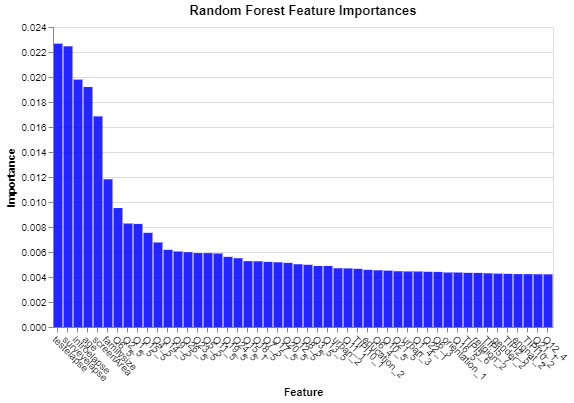

In [99]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'blue')

From above Figure 2. (include figure number in function above)we can see that the testelapse, surveyelapse and introelapse are first three important features followed by age and screenArea. 

**Intuitively it makes sence as these elapse times are based on how much time the person has taken for:-**

* **`introelapse`**:  The time spent on the introduction/landing page (in seconds) `continuous`
* **`testelapse`**:   The time spent on the RWAS questions `continuous`
* **`surveyelapse`**: The time spent answering the rest of the demographic and survey questions `continuous`

However, we will consider these during the - [Section 6 (Hyperparameter Tuning)](#6). 

## SPSA wrapper method

In [100]:
clf = KNeighborsClassifier(n_neighbors=15)
from SpFtSel import SpFtSel

sp_engine = SpFtSel(Data, target.ravel(), clf, 'accuracy')

In [101]:
np.random.seed(seed)
sp_output = sp_engine.run(num_features).results

spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')
spFtSel-INFO: Scoring metric: accuracy
spFtSel-INFO: Number of features: 339
spFtSel-INFO: Number of observations: 25136
spFtSel-INFO: iter: 0, value: 0.337, std: 0.007, num. features: 50, best value: 0.337
spFtSel-INFO: iter: 5, value: 0.36, std: 0.004, num. features: 50, best value: 0.366
spFtSel-INFO: iter: 10, value: 0.368, std: 0.006, num. features: 50, best value: 0.373
spFtSel-INFO: iter: 15, value: 0.363, std: 0.004, num. features: 50, best value: 0.373
spFtSel-INFO: iter: 20, value: 0.368, std: 0.006, num. features: 50, best value: 0.373
spFtSel-INFO: iter: 25, value: 0.366, std: 0.004, num. features: 50, best value: 0.373
spFtSel-INFO: iter: 30, value: 0.366, std: 0.006, num. features: 50, best value: 0.373
spFtSel-INFO: spFtSel run completed.


In [102]:
fs_indices_spsa = sp_output.get('features')
fs_indices_spsa

array([ 95,  41, 127,  72, 204, 317, 324,  59, 200, 157, 309,  16,  86,
       146,  34, 198, 107,  23, 332, 313,  47,  42,  24,  73, 278, 199,
        75, 114, 142, 119,  27, 294,  40, 164,  82, 147, 297, 237,  39,
       302, 233, 165, 248,  61, 195, 174,  74, 288, 228, 243], dtype=int64)

In [103]:
best_features_spsa = colList[fs_indices_spsa].values
best_features_spsa

array(['Q15_5', 'Q6_5', 'Q21_1', 'Q12_0', 'TIPI6_2', 'married_1',
       'race_black_0', 'Q9_5', 'TIPI5_6', 'Q26_1', 'orientation_2',
       'Q2_4', 'Q14_2', 'Q24_2', 'Q5_4', 'TIPI5_4', 'Q17_5', 'Q3_5',
       'race_nativeau_0', 'voted_0', 'Q7_5', 'Q7_0', 'Q4_0', 'Q12_1',
       'education_4', 'TIPI5_5', 'Q12_3', 'Q19_0', 'Q23_4', 'Q19_5',
       'Q4_3', 'religion_0', 'Q6_4', 'TIPI1_2', 'Q13_4', 'Q24_3',
       'religion_3', 'TIPI10_3', 'Q6_3', 'religion_8', 'TIPI9_7',
       'TIPI1_3', 'VCL4_0', 'Q10_1', 'TIPI5_1', 'TIPI2_4', 'Q12_2',
       'engnat_1', 'TIPI9_2', 'VCL1_1'], dtype=object)

In [104]:
feature_importances_spsa = sp_output.get('importance')
feature_importances_spsa

array([0.5127061 , 0.51064457, 0.51057586, 0.51053294, 0.51039725,
       0.51036009, 0.51023754, 0.51001574, 0.50917315, 0.50914597,
       0.50901591, 0.50887142, 0.50822562, 0.50794858, 0.5078897 ,
       0.50786523, 0.50783002, 0.50747753, 0.50733798, 0.5070357 ,
       0.50694893, 0.5069166 , 0.5069094 , 0.50679043, 0.50677487,
       0.50675364, 0.50669505, 0.50654975, 0.50648395, 0.50610148,
       0.506031  , 0.50598206, 0.50596647, 0.50587995, 0.50587396,
       0.50585862, 0.50581603, 0.50580739, 0.5058072 , 0.50579831,
       0.50578283, 0.50575721, 0.50570967, 0.50568909, 0.5056353 ,
       0.50562611, 0.50532042, 0.50521938, 0.50521653, 0.50520349])

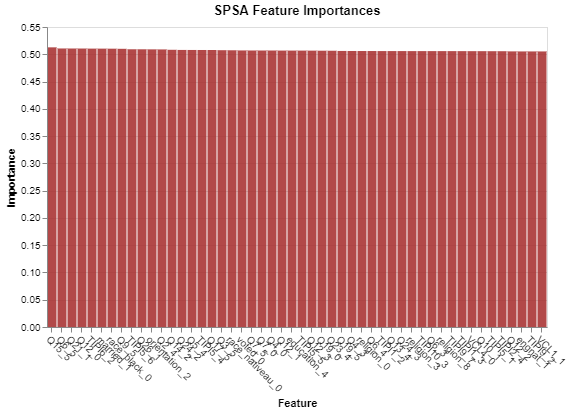

In [105]:
plot_imp(best_features_spsa, feature_importances_spsa, 'SPSA', 'brown')

In [78]:
#impFeatures = np.unique(np.concatenate((best_features_rfi,best_features_spsa),0))
print(impFeatures)

['Q10_1' 'Q10_5' 'Q11_1' 'Q11_5' 'Q12_0' 'Q12_1' 'Q12_2' 'Q12_3' 'Q12_4'
 'Q12_5' 'Q13_4' 'Q13_5' 'Q14_2' 'Q14_5' 'Q15_1' 'Q15_5' 'Q16_5' 'Q17_5'
 'Q18_5' 'Q19_0' 'Q19_5' 'Q1_4' 'Q1_5' 'Q20_5' 'Q21_1' 'Q21_5' 'Q22_1'
 'Q23_4' 'Q23_5' 'Q24_2' 'Q24_3' 'Q24_5' 'Q26_1' 'Q26_5' 'Q2_4' 'Q2_5'
 'Q3_5' 'Q4_0' 'Q4_3' 'Q4_5' 'Q5_4' 'Q5_5' 'Q6_3' 'Q6_4' 'Q6_5' 'Q7_0'
 'Q7_5' 'Q8_5' 'Q9_5' 'TIPI10_1' 'TIPI10_2' 'TIPI10_3' 'TIPI1_2' 'TIPI1_3'
 'TIPI2_4' 'TIPI2_5' 'TIPI5_1' 'TIPI5_4' 'TIPI5_5' 'TIPI5_6' 'TIPI5_7'
 'TIPI6_2' 'TIPI9_2' 'TIPI9_7' 'VCL1_1' 'VCL4_0' 'age' 'education_2'
 'education_4' 'engnat_1' 'engnat_2' 'familysize' 'gender_2' 'introelapse'
 'married_1' 'orientation_1' 'orientation_2' 'race_black_0'
 'race_nativeau_0' 'religion_0' 'religion_2' 'religion_3' 'religion_8'
 'screenArea' 'surveyelapse' 'testelapse' 'urban_2' 'urban_3' 'voted_0']


In [79]:
# Writing them to pickle file: to be commented after execution
# with open('data.impFeatures', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(impFeatures, f, pickle.HIGHEST_PROTOCOL)

# Data Sampling & Train-Test Splitting

Considering our data size which is 25k+ rows, we will be using the entire dataset instead of random sampling. During initial modelling phase we used the logic to try out with different samples. 

Also, as we noticed from - [Section 1 (Problem)](#1), the target variable **`nerdy`** levels are not quiet balanced, hence while performing train test split we will partition the dataset using 70:30 ratio using statification sampling approach. 

In [35]:
# # reading pickle files saved
# with open('Data_sample', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     Data_sample = pickle.load(f)

In [36]:
# with open('target_sample', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     target_sample = pickle.load(f)

In [44]:
n_samples = len(Data) 

Data_sample = pd.DataFrame(Data).sample(n=n_samples, random_state=8).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=8).values

In [45]:
n_samples = len(Data_sel) 

Data_sel_sample = pd.DataFrame(Data_sel).sample(n=n_samples, random_state=8).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=8).values

In [46]:
print(Data_sample.shape)
print(target_sample.shape)

(25136, 339)
(25136, 1)


In [47]:
print(Data_sel_sample.shape)
print(target_sample.shape)

(25136, 89)
(25136, 1)


In [48]:
from sklearn.model_selection import train_test_split

Data_sample_train, Data_sample_test, \
target_sample_train, target_sample_test = train_test_split(Data_sample, target_sample, 
                                                    test_size = 0.3, random_state=seed,
                                                    stratify = target_sample)

print(Data_sample_train.shape)
print(Data_sample_test.shape)

(17595, 339)
(7541, 339)


In [49]:
from sklearn.model_selection import train_test_split

Data_sel_sample_train, Data_sel_sample_test, \
target_sample_train, target_sample_test = train_test_split(Data_sel_sample, target_sample, 
                                                    test_size = 0.3, random_state=seed,
                                                    stratify = target_sample)

In [50]:
print(Data_sel_sample_train.shape)
print(Data_sel_sample_test.shape)

(17595, 89)
(7541, 89)


In [51]:
print(target_sample_train.shape)
print(target_sample_test.shape)

(17595, 1)
(7541, 1)


In [52]:
### pickle files for further analysis - to be commented after execution

In [53]:
# with open('data.scaler.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(Data_scaler, f, pickle.HIGHEST_PROTOCOL)

In [54]:
# with open('data.corr.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(correlationMatrixData, f, pickle.HIGHEST_PROTOCOL)

In [55]:
# with open('data.model.rfi', 'wb') as f:
#     pickle.dump(model_rfi, f, pickle.HIGHEST_PROTOCOL)

In [56]:
# with open('data.fs_indices_spsa', 'wb') as f:
#     pickle.dump(fs_indices_spsa, f, pickle.HIGHEST_PROTOCOL)

In [57]:
with open('Data_sample', 'wb') as f:
    pickle.dump(Data_sample, f, pickle.HIGHEST_PROTOCOL)

In [58]:
with open('target_sample', 'wb') as f:
    pickle.dump(target_sample, f, pickle.HIGHEST_PROTOCOL)

In [59]:
with open('Data_sel_sample', 'wb') as f:
    pickle.dump(Data_sel_sample, f, pickle.HIGHEST_PROTOCOL)

# Model Evaluation Strategy <a class="anchor" id="5"></a> 

Our model evaluation strategy is to try different train model by combining hypertuning with gridsearchCV techniques. Considering our datasize and computational resource constraints we chose this approach of regressive tuning. In this approach we try different algorithms with hypertuning parameters using selected important features as well as all the 339 features and then further test them on the test split data to choose the best model based on the `accuracy` as metric.  For each model, we will use 5-fold stratified cross-validation evaluation method.

The following algorithms were used for the analysis: 

* K-Nearest Neighbors (KNN),
* Random Forest,
* Multi nomial Naive Bayes (NB),
* Gower Classifier,
* CatBoost

Other algorithms tried bu have not included in the report due to computational contraints are Linear Discriminant Analysis and sgClassifier. 

In [60]:
#from sklearn.model_selection import StratifiedKFold, GridSearchCV
cv_method = StratifiedKFold(n_splits=5, random_state=seed)

# Hyperparameter Tuning <a class="anchor" id="6"></a>

## K-Nearest Neighbors (KNN)

In [93]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold

model = KNeighborsClassifier()
cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)

n_neighbors =  [1,3,5,7,10,15]
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=n_neighbors, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 10, 15], 'weights': ['uniform', 'distance']}


In [94]:
grid = GridSearchCV(estimator=model, param_grid = param_grid, 
                    cv = cv_method, n_jobs=-2,
                    scoring='accuracy',
                    return_train_score=True)

In [62]:
#not executed again as we have saved the pickled object
grid.fit(Data_sample_train,target_sample_train)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000002662601C2B0>,
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'n_neighbors': [1, 3, 5, 7, 10, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [61]:
with open('grid_knn', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    gridKNN = pickle.load(f)

In [62]:
gridKNN.best_params_

{'n_neighbors': 15, 'weights': 'uniform'}

In [63]:
gridKNN.best_score_

0.3856588045846358

In [64]:
gridKNN.cv_results_['mean_test_score']

array([0.32924126, 0.32924126, 0.32226958, 0.34454864, 0.3597613 ,
       0.36186417, 0.36836222, 0.36983992, 0.37845979, 0.37857346,
       0.3856588 , 0.38340438])

In [65]:
# to comment after execution
with open('grid_knn', 'wb') as f:
    pickle.dump(grid, f, pickle.HIGHEST_PROTOCOL)

### Further tuning

Let us further fine tune our KNN algorithm with n_neighbour = 15 and with impFeatures on entire data. This time we can further enhance the cv_method with StratifiedKFold instead of RepeatedKFold

In [99]:
model = KNeighborsClassifier()
cv_method = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
n_neighbors =  [15]
weight_options = ['uniform']
p = [1, 2, 5]

param_grid = dict(n_neighbors=n_neighbors, weights=weight_options, p = p)
print(param_grid)

{'n_neighbors': [15], 'weights': ['uniform'], 'p': [1, 2, 5]}


In [100]:
grid_ftKNN = GridSearchCV(estimator=model, param_grid = param_grid, 
                    cv = cv_method, n_jobs=-2,
                    scoring='accuracy',
                    verbose = 5,
                    return_train_score=True)

In [169]:
#not executed again due to computational resource contrain, using pickle file to show results
grid_ftKNN.fit(Data_sel_sample_train,target_sample_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed: 14.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=True),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'n_neighbors': [15], 'weights': ['uniform'], 'p': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [66]:
with open('grid_ftknn', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid_ftKNN = pickle.load(f)

In [102]:
grid_ftKNN.best_params_

{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}

In [103]:
grid_ftKNN.best_score_

0.38886047172492183

In [104]:
grid_ftKNN.cv_results_['mean_test_score']

array([0.38886047, 0.38664393, 0.38579142])

In [176]:
# #comment after execution
# with open('grid_ftknn', 'wb') as f:
#     pickle.dump(grid_ftKNN, f, pickle.HIGHEST_PROTOCOL)

## Random Forest

In [105]:
model = RandomForestClassifier()
cv_method = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
parameters = {'n_estimators'  : [20,30,40,50,100,200],
              'bootstrap'     : ['True','False'],
              'max_depth'     : [5,10,20],
              'min_samples_leaf' : [2,5,7]
             }

In [106]:
grid = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)

In [ ]:
#not executed again
grid.fit(Data_sample_train,target_sample_train)

In [67]:
warnings.filterwarnings("ignore")

with open('random.forest.grid.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    gridRF = pickle.load(f)

In [109]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",gridRF.best_estimator_)
print("\n The best score across ALL searched params:\n",gridRF.best_score_)
print("\n The best parameters across ALL searched params:\n",gridRF.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 The best score across ALL searched params:
 0.42171071327081555

 The best parameters across ALL searched params:
 {'bootstrap': 'True', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 200}



Based on above tuning parameters we optimize the RandomForestClassifier with these fine tunes parameters and fit them on the data. We are saving the model to a pickle object and will be using them for making oredictions at next section.

In [ ]:
#not executed again
randomForestClassifierModel = RandomForestClassifier(n_jobs=-2, random_state=seed, 
                                                     bootstrap=True, max_depth= 20, 
                                                     min_samples_leaf= 7, n_estimators= 200)

randomForestClassifierModel.fit(Data_sample_train,target_sample_train.ravel())

In [68]:
warnings.filterwarnings("ignore")

with open('random.forest.best.model.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    randomForestClassifierModel = pickle.load(f)

### Further Tuning

We further fine tune the Random Foresr classifier with selected features and hoose the nest model that can be used for predictions 

In [ ]:
#not executed again
grid_sel = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [69]:
warnings.filterwarnings("ignore")

with open('random.forest.grid.selected.features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid_sel = pickle.load(f)

In [112]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid_sel.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_sel.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_sel.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 The best score across ALL searched params:
 0.42119920431940894

 The best parameters across ALL searched params:
 {'bootstrap': 'True', 'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 200}



In [ ]:
#not executed
randomForestClassifierModel_sel = RandomForestClassifier(n_jobs=-2, random_state=seed, bootstrap=True, max_depth= 10, min_samples_leaf= 7, n_estimators= 200)
randomForestClassifierModel_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [70]:
warnings.filterwarnings("ignore")

with open('random.forest.best.model.selected.features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    randomForestClassifierModel_sel = pickle.load(f)

## Multinomial Naive Bayes 

In [114]:
model = MultinomialNB()
cv_method = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
parameters = {'alpha'  : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
             }

In [ ]:
#not executed again
grid = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(Data_sample_train,target_sample_train.ravel())

In [115]:
warnings.filterwarnings("ignore")

with open('navie.bayes.mb.grid.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid = pickle.load(f)

In [116]:
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)

 The best score across ALL searched params:
 0.3907928388746803

 The best parameters across ALL searched params:
 {'alpha': 0.8}



In [ ]:
#not executed again
nb = MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)
nb.fit(Data_sample_train,target_sample_train.ravel())

In [71]:
warnings.filterwarnings("ignore")

with open('naive.bayes.mb.best.model.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    nb = pickle.load(f)

### Further Tuning

In [ ]:
#not executed again
grid_sel = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [118]:
warnings.filterwarnings("ignore")

with open('navie.bayes.mb.grid.selected.features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid_sel = pickle.load(f)

In [119]:
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid_sel.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_sel.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_sel.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

 The best score across ALL searched params:
 0.40710429099175904

 The best parameters across ALL searched params:
 {'alpha': 1}



In [ ]:
#not executed again
nb_sel = MultinomialNB(alpha=1)
nb_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [72]:
warnings.filterwarnings("ignore")

with open('naive.bayes.mb.best.model.selected.features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    nb_sel = pickle.load(f)

## Multinomial Naive Bayes - without numerical

One of the main advantages og Naive Bayes is that it performs well on categorical data types. If numerical features are there then the normality assumption must hold true which the numerical features for our dataset deviates. Hence, let us try the same algorithm with just categorical features and see if we have acceptable improvement in the accuracy. 

In [ ]:
model = MultinomialNB()
cv_method = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
parameters = {'alpha'  : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
             }

In [ ]:
grid = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(Data_sample_train,target_sample_train.ravel())

In [3]:
warnings.filterwarnings("ignore")

with open('navie.bayes.mb.grid.without.numerical.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid = pickle.load(f)

In [4]:
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

 The best score across ALL searched params:
 0.3903381642512077

 The best parameters across ALL searched params:
 {'alpha': 0.5}



In [ ]:
nbwn = MultinomialNB(alpha=0.5)
nbwn.fit(Data_sample_train,target_sample_train.ravel())

In [73]:
warnings.filterwarnings("ignore")

with open('naive.bayes.mb.best.model.without.numerical.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    nbwn = pickle.load(f)

### Further Tuning

In [74]:
categorical_features = list()
for i, c in enumerate(Data_sel_sample.T):
    if len(np.unique(c)) == 2:
        categorical_features.append(i) #True: on hot coded columns, False: numeric MinMaxscaled columns.
del(c, i)

In [75]:
Data_sel_sample = Data_sel_sample[:,categorical_features]
Data_sel_sample.shape

(25136, 83)

In [ ]:
model = MultinomialNB()
cv_method = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
parameters = {'alpha'  : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
             }

In [ ]:
grid_sel = GridSearchCV(estimator=model, param_grid = parameters, 
                    cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [6]:
warnings.filterwarnings("ignore")

with open('navie.bayes.mb.grid.selected.features.without.numerical.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid_sel = pickle.load(f)

In [7]:
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid_sel.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_sel.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_sel.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

 The best score across ALL searched params:
 0.4057971014492754

 The best parameters across ALL searched params:
 {'alpha': 1}



In [ ]:
nbwn_sel = MultinomialNB(alpha=1)
nbwn_sel.fit(Data_sel_sample_train,target_sample_train.ravel())

In [76]:
warnings.filterwarnings("ignore")

with open('naive.bayes.mb.best.model.selected.features.without.numerical.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    nbwn_sel = pickle.load(f)

 # Other algorithms <a class="anchor" id="7"></a>

As a Bonus step, we extended our Analysis further with couple of other algorithms such as **`Gower classifier`** and **`Cat Boost`**. 

## Gower Classifier

For Gower classifier, with the help of [research papers and github research flows](https://github.com/scikit-learn/scikit-learn/pull/9555), we customized the existing function that defines the gower distance caluclation for our datset and perform a customized grid search cv. Based on our research, gower distance measure is into existence from 1971, however it is still work in progress to integrate this measure into scikitLearn. 

Below is the function and our trial resuts for our dataset using the defined gower classifier function. 

In [111]:
# Gower classifier function
class KNNGowerSimilarityClassifer():
    def __init__(self):
        self._k = 1
        
    def _precompute_metric_params(self, X, Y, metric=None, **kwds):
        RANGE = kwds['RANGE']
        MIN = np.nanmin(X, axis=0)
        if X is not Y:
            MIN = np.nanmin([np.nanmin(Y, axis=0), MIN], axis=0)
        MAX = None
        if type(RANGE) is bool:
            MAX = np.nanmax(X, axis=0)
            if X is not Y:
                MAX = np.nanmax([np.nanmax(Y, axis=0), MAX], axis=0)
        else:
            MAX = MIN + RANGE
        return {'MIN': MIN, 'MAX': MAX}
    
    def _return_float_dtype(self, X, Y):
        if not issparse(X) and not isinstance(X, np.ndarray):
            X = np.asarray(X)

        if Y is None:
            Y_dtype = X.dtype
        elif not issparse(Y) and not isinstance(Y, np.ndarray):
            Y = np.asarray(Y)
            Y_dtype = Y.dtype
        else:
            Y_dtype = Y.dtype

        if X.dtype == Y_dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float

        return X, Y, dtype

    def _detect_categorical_features(self, X, categorical_features=None):
        _, n_cols = np.shape(X)
        # Automatic detection of categorical features
        categorical_features_detected = np.zeros(n_cols, dtype=bool)
        for col in range(0, n_cols):
            if not np.issubdtype(type(X[0][col]), np.number):
                categorical_features_detected[col] = True

        categorical_features_obj = categorical_features_detected
        # Numerical categorical features can't be automatically detected
        categorical_features_num = np.zeros(n_cols, dtype=bool)

        if categorical_features is not None:
            categorical_features = np.asarray(categorical_features)
            if np.issubdtype(categorical_features.dtype, np.integer):
                new_categorical_features = np.zeros(n_cols, dtype=bool)
                new_categorical_features[categorical_features] = True
                categorical_features = new_categorical_features

            # Identifies categorical values represented by objects or numbers
            categorical_features_num = \
                categorical_features_detected != categorical_features
            categorical_features_obj = \
                categorical_features_detected & categorical_features

        return categorical_features_obj, categorical_features_num, \
            ~(categorical_features_obj | categorical_features_num)

    def _check_pairwise_arrays(self, X, Y, precomputed=False, dtype=None,
                              force_all_finite=True):

        X, Y, dtype_float = self._return_float_dtype(X, Y)

        estimator = 'check_pairwise_arrays'
        if dtype is None:
            dtype = dtype_float

        if Y is X or Y is None:
            X = Y = utils.check_array(X, accept_sparse='csr', dtype=dtype,
                                estimator=estimator,
                                force_all_finite=force_all_finite)
        else:
            X = utils.check_array(X, accept_sparse='csr', dtype=dtype,
                            estimator=estimator,
                            force_all_finite=force_all_finite)
            Y = utils.check_array(Y, accept_sparse='csr', dtype=dtype,
                            estimator=estimator,
                            force_all_finite=force_all_finite)

        if precomputed:
            if X.shape[1] != Y.shape[0]:
                raise ValueError("Precomputed metric requires shape "
                                 "(n_queries, n_indexed). Got (%d, %d) "
                                 "for %d indexed." %
                                 (X.shape[0], X.shape[1], Y.shape[0]))
        elif X.shape[1] != Y.shape[1]:
            raise ValueError("Incompatible dimension for X and Y matrices: "
                             "X.shape[1] == %d while Y.shape[1] == %d" % (
                                 X.shape[1], Y.shape[1]))

        return X, Y

    def _gower_distances(self, X, Y=None, categorical_features=None, scale=True):

        if issparse(X) or issparse(Y):
            raise TypeError("Gower distance does not support sparse matrices")

        type_scale = type(scale)
        if not (type_scale is bool or type_scale is list or
                type_scale is np.array):
            raise TypeError("Parameter scale must be boolean, list, or array")

        if X is None or len(X) == 0:
            raise ValueError("X can not be None or empty")

        y_is_not_none = Y is not None

        # It is necessary to convert to ndarray in advance to define the dtype
        # as np.object, otherwise numeric columns will be converted to string
        # if there are other string columns.
        if not isinstance(X, np.ndarray):
            X = np.asarray(X, dtype=np.object)

        if y_is_not_none and not isinstance(Y, np.ndarray):
            Y = np.asarray(Y, dtype=np.object)

        X, Y = self._check_pairwise_arrays(X, Y, precomputed=False, dtype=X.dtype,
                                     force_all_finite=False)

        n_rows, n_cols = X.shape

        categorical_features_obj, categorical_features_num, numerical_features = \
            self._detect_categorical_features(X, categorical_features)

        # Categorical columns
        X_cat_obj = X[:, categorical_features_obj].astype(np.object)
        X_cat_num = X[:, categorical_features_num].astype(np.float)

        # Numerical columns
        X_num = X[:, numerical_features].astype(np.float)

        Y_cat_obj = None
        Y_cat_num = None
        Y_num = None
        if y_is_not_none:
            Y_cat_obj = Y[:, categorical_features_obj].astype(np.object)
            Y_cat_num = Y[:, categorical_features_num].astype(np.float)
            Y_num = Y[:, numerical_features].astype(np.float)
        else:
            Y_cat_obj = X_cat_obj
            Y_cat_num = X_cat_num
            Y_num = X_num

        num_cols = X_num.shape[1]
        n_col_num_present = num_cols > 0
        n_col_cat_obj_present = X_cat_obj.shape[1] > 0
        n_col_cat_num_present = X_cat_num.shape[1] > 0

        # Calculates the min and max values, and if requested, scale the
        # input values as proposed by the Gower's paper.
        if n_col_num_present:
            params = self._precompute_metric_params(X_num, Y_num, metric='gower',
                                               RANGE=scale)

            # Scales the numeric values between 0 and 1.
            if scale:
                scaler = preprocessing.MinMaxScaler().fit([params['MIN'], params['MAX']])
                X_num = scaler.transform(X_num)
                if y_is_not_none:
                    Y_num = scaler.transform(Y_num)
                else:
                    Y_num = X_num
            # If not, checks if the data is scaled.
            elif np.min(params['MIN']) < 0 or np.max(params['MAX']) > 1:
                raise ValueError("Input data is not scaled between 0 and 1.")

        y_n_rows = Y.shape[0]
        D = np.zeros((n_rows, y_n_rows), dtype=np.float)

        for i in range(n_rows):
            j_start = i

            # for non square results
            if n_rows != y_n_rows or y_is_not_none:
                j_start = 0
            sum_s = 0
            n_cols_not_missing = 0

            # sum and missing values treatment for each type of data, if available
            if n_col_cat_obj_present:
                row_cat_none = ~(np.equal(X_cat_obj[i, :], None) |
                                 np.equal(Y_cat_obj[j_start:n_rows, :], None))

                n_cols_not_missing = np.sum(row_cat_none.astype(np.int), axis=1)
                sum_s = (~np.equal(X_cat_obj[i, :], Y_cat_obj[j_start:n_rows, :])
                         & row_cat_none).astype(np.int).sum(axis=1)

            if n_col_cat_num_present:
                row_cat_nan = ~(np.isnan(X_cat_num[i, :]) |
                                np.isnan(Y_cat_num[j_start:n_rows, :]))

                n_cols_not_missing = \
                    n_cols_not_missing + \
                    np.sum(row_cat_nan.astype(np.int), axis=1)

                sum_s = sum_s + (~np.equal(X_cat_num[i, :],
                                           Y_cat_num[j_start:n_rows, :])
                                 & row_cat_nan).astype(np.int).sum(axis=1)

            if n_col_num_present:
                n_cols_not_missing = n_cols_not_missing + \
                                     np.sum((~(np.isnan(X_num[i, :]) |
                                               np.isnan(Y_num[j_start:n_rows, :])))
                                            .astype(np.int), axis=1)

                sum_s = sum_s + np.nansum(
                    np.absolute(X_num[i, :] - Y_num[j_start:n_rows, :]), axis=1)

            result = np.divide(sum_s, n_cols_not_missing,
                               out=np.full(n_cols_not_missing.shape, np.nan),
                               where=n_cols_not_missing != 0)

            D[i, j_start:] = result
            if not y_is_not_none:
                D[i:, j_start] = result

        return D

    def _sortIndicies(self, c, reverse=False):
        output = [0] * len(c)
        for i, x in enumerate(sorted(range(len(c)), key=lambda y: c[y])):
            output[x] = (i, len(c) - i - 1)[reverse]
        return output
    
    def fit(self, k, x_train, x_test, y_train, categorical_features=None, scale=True):
        if not isinstance(x_train, np.ndarray):
            x_train = np.asarray(x_train)
        if not isinstance(x_test, np.ndarray):
            x_test = np.asarray(x_test)
        if not isinstance(y_train, np.ndarray):
            y_train = np.asarray(y_train)
        self._x_train = x_train
        self._x_test = x_test
        self._y_train = y_train
        self._k =k
        self._distances = self._gower_distances(x_train, x_test, categorical_features=categorical_features, scale=scale)
    
    def predict(self):
        predictions = []
        for i in range(self._distances.shape[1]):
            indicies = self._sortIndicies(self._distances[:,i], reverse=False) #np.argsort(self._distances[:,i])
            values=[]
            for j in range(self._k):
                v = self._y_train[indicies.index(j),0]
                values.append(v)
            counts = np.bincount(np.asarray(values))
            predictions.append(np.argmax(counts))
        self._predictions = predictions
        return predictions

class KNNGowerSimilarityClassiferGridSearch:
    def __init__(self):
        self.score = []
        self.differenceScore = []
        self.params = []
        self.__RANDOM_STATE = 0

    def _cross_val(self, X, Y, param, categorial_features, n_splits=5):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                              random_state=self.__RANDOM_STATE)
        print(param)
        for tr_ind, val_ind in skf.split(X, Y):
            X_train = X[tr_ind]
            y_train = Y[tr_ind]
            X_valid = X[val_ind]
            y_valid = Y[val_ind]
            model = KNNGowerSimilarityClassifer()
            self.params.append(param['k'])
            model.fit(param['k'], X_train, X_valid, y_train, categorial_features)
            predictions = model.predict()
            acc = metrics.accuracy_score(y_valid, predictions)
            self.score.append(acc)
            c = abs(np.asarray(y_valid) - predictions) > 2
            self.differenceScore.append(np.sum(c))
    
    def _sortIndicies(self, reverse=True):
        output = [0] * len(self.score)
        for i, x in enumerate(sorted(range(len(self.score)), key=lambda y: self.score[y])):
            output[x] = (i, len(self.score) - i - 1)[reverse]
        return output

    def gridSearchCV(self, X, Y, params, categorial_features, n_splits=5):
        if not isinstance(X, np.ndarray):
            X = np.asarray(X)
        if not isinstance(Y, np.ndarray):
            Y = np.asarray(Y)
        for p in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
            self._cross_val(X, Y, p, categorial_features, n_splits)
        best = (self._sortIndicies()).index(0)
        self.best_estimate = self.params[best]

The below function basically sets the categorical features parametr used in the function above to be either true or false based on the feature.dtype. We came up with this dynamic way of assigning as our dataset has a combination of both categorical and numeric type data and it was necessary for us to define this way for the algorithm to perform efficiently. 

In [128]:
#not executed again
categorical_features = list()
for c in Data_sample.T:
    categorical_features.append(len(np.unique(c)) == 2) #True: on hot coded columns, False: numeric MinMaxscaled columns.
del(c)

In [ ]:
#not executed again
grid = KNNGowerSimilarityClassiferGridSearch()
grid.gridSearchCV(Data_sample_train, target_sample_train, {
        'k': np.asarray(range(1,20,2))
        },categorical_features, 7)

In [81]:
warnings.filterwarnings("ignore")

with open('data.gower.grid', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid = pickle.load(f)

In [82]:
print(grid.score)
print(grid.params)

[0.32710651828298887, 0.3379721669980119, 0.32524850894632207, 0.3162291169451074, 0.3310783923597294, 0.33240445859872614, 0.3203187250996016, 0.3199523052464229, 0.3359840954274354, 0.3240556660039761, 0.3046937151949085, 0.32590529247910865, 0.3379777070063694, 0.3183266932270916, 0.3600953895071542, 0.3658051689860835, 0.3594433399602386, 0.3520286396181384, 0.3728611221647433, 0.3630573248407643, 0.36294820717131476, 0.36486486486486486, 0.3757455268389662, 0.3757455268389662, 0.3627684964200477, 0.3748507759649821, 0.3861464968152866, 0.3804780876494024, 0.3783783783783784, 0.3757455268389662, 0.37654075546719684, 0.3723150357995227, 0.38400318344608037, 0.383359872611465, 0.3840637450199203, 0.37639109697933226, 0.3809145129224652, 0.37375745526838966, 0.373508353221957, 0.38440111420612816, 0.3964968152866242, 0.38725099601593627, 0.3863275039745628, 0.3892644135188867, 0.3797216699801193, 0.373508353221957, 0.39434938320732194, 0.3976910828025478, 0.3944223107569721, 0.3899046

In [83]:
avg_scores = []
avg_scores = [0] * len(np.unique(grid.params))
indx = -1
p = 0

for s, score in enumerate(grid.score):
    if p != grid.params[s]:
        p = grid.params[s]
        indx = indx + 1
    avg_scores[indx] = avg_scores[indx] + score

for v in range(len(avg_scores)):
    avg_scores[v] = avg_scores[v] / (len(grid.params) / len(np.unique(grid.params)))
best_estimate = np.unique(grid.params)[np.argmax(avg_scores)]
print(best_estimate)

19


In [ ]:
from scipy.sparse import issparse
from sklearn import preprocessing, linear_model, utils
model = KNNGowerSimilarityClassifer()
model.fit(best_estimate, Data_sample_train,Data_sample_test,target_sample_train,categorical_features)

In [134]:
# with open('data.gower.model', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [84]:
warnings.filterwarnings("ignore")

with open('data.gower.model', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    model_gw = pickle.load(f)

In [102]:
pred_gw = model_gw.predict()

In [103]:
metrics.accuracy_score(target_sample_test, pred_gw)

0.38363612253016843

### Further tuning with Gower classifier

In [ ]:
#not executed again
grid_sel = KNNGowerSimilarityClassiferGridSearch()
grid_sel.gridSearchCV(Data_sel_sample_train, target_sample_train, {
        'k': np.asarray(range(1,20,2))
        },categorical_features, 7)

In [85]:
warnings.filterwarnings("ignore")

with open('data.gower.selected.features.grid', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    grid_sel = pickle.load(f)

In [86]:
print(grid_sel.score)
print(grid_sel.params)

[0.3235294117647059, 0.31451292246520873, 0.32166998011928427, 0.3273667462211615, 0.3263032232391564, 0.31011146496815284, 0.31992031872509963, 0.2937201907790143, 0.3073558648111332, 0.3089463220675944, 0.29832935560859186, 0.3131715081575806, 0.30294585987261147, 0.3, 0.352543720190779, 0.3518886679920477, 0.34791252485089463, 0.33890214797136037, 0.34779148428173495, 0.34912420382165604, 0.3537848605577689, 0.36486486486486486, 0.3753479125248509, 0.36540755467196817, 0.3500397772474145, 0.358933545563072, 0.37221337579617836, 0.3637450199203187, 0.3688394276629571, 0.37932405566600397, 0.37256461232604376, 0.3524264120922832, 0.3680859530441703, 0.3857484076433121, 0.36932270916334664, 0.3847376788553259, 0.3900596421471173, 0.37216699801192843, 0.3556085918854415, 0.3772383605252686, 0.3929140127388535, 0.3784860557768924, 0.3827503974562798, 0.39443339960238566, 0.3809145129224652, 0.3647573587907717, 0.3724631914046956, 0.392515923566879, 0.3856573705179283, 0.38910969793322736

In [87]:
categorical_features = list()
for c in Data_sel_sample.T:
    categorical_features.append(len(np.unique(c)) == 2) #True: on hot coded columns, False: numeric MinMaxscaled columns.
del(c)

In [88]:
avg_scores = []
avg_scores = [0] * len(np.unique(grid_sel.params))
indx = -1
p = 0

for s, score in enumerate(grid_sel.score):
    if p != grid_sel.params[s]:
        p = grid_sel.params[s]
        indx = indx + 1
    avg_scores[indx] = avg_scores[indx] + score

for v in range(len(avg_scores)):
    avg_scores[v] = avg_scores[v] / (len(grid_sel.params)/len(np.unique(grid_sel.params)))
best_estimate = np.unique(grid_sel.params)[np.argmax(avg_scores)]
print(best_estimate)

19


In [149]:
model_sel = KNNGowerSimilarityClassifer()
model_sel.fit(grid_sel.best_estimate, Data_sel_sample_train, Data_sel_sample_test, \
              target_sample_train, categorical_features)

In [150]:
# with open('data.gower.selected.features.model', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(model_sel, f, pickle.HIGHEST_PROTOCOL)

In [89]:
warnings.filterwarnings("ignore")

with open('data.gower.selected.features.model', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    model_sel = pickle.load(f)

In [104]:
pred_gwSel = model_sel.predict()

In [105]:
metrics.accuracy_score(target_sample_test, pred_gwSel)

0.39146001856517704

# Performance Comparison <a class="anchor" id="8"></a>

Next step of the modeling is to test the performance of the chosen candidate models. For this we have chosen the same cross validation approach on **test data**. Considering the fact that cross validation is a random process we can further analyse by  performing a pairwise ttest. In this process we will determine any difference between the performance of the chosen models in comparison with the other. We use `accuracy` as our scoring metric. 

From above model evaluation section we have 6 candidate models; two each from KNN, Multinmial Naive Bayes and Random Forest Classifier. We will first proceed with the cross validation of those models on test data and one model from each category and use them for the pairwise ttest.

## KNN

In [90]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=5, random_state=seed)

cv_results_KNN = cross_val_score(estimator=gridKNN.best_estimator_,
                                 X=Data_sample_test,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='accuracy')
cv_results_KNN.mean()

0.3821737335674316

In [91]:
cv_results_ftKNN = cross_val_score(estimator=grid_ftKNN.best_estimator_,
                                 X=Data_sel_sample_test,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='accuracy')
cv_results_ftKNN.mean()

0.38296658669395256

## Random Forest

In [92]:
cv_results_rf = cross_val_score(estimator=randomForestClassifierModel,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_rf.mean()

0.4141394095086975

In [93]:
cv_results_rfSel = cross_val_score(estimator=randomForestClassifierModel_sel,
                                X=Data_sel_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_rfSel.mean()

0.41321735657864656

## Multinomial Naive Bayes

In [94]:
cv_results_NB = cross_val_score(estimator=nb,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_NB.mean()

0.39569934382268845

In [95]:
cv_results_NB_Sel = cross_val_score(estimator=nb_sel,
                                X=Data_sel_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_NB_Sel.mean()

0.39994503531622316

### MNB - without numerical features

In [96]:
cv_results_NBWN = cross_val_score(estimator=nbwn,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_NBWN.mean()

0.39304646583776515

In [97]:
cv_results_NBWN_Sel = cross_val_score(estimator=nbwn_sel,
                                X=Data_sel_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='accuracy')
cv_results_NBWN_Sel.mean()

0.39994503531622316

Considering the performance of Naive Bayes with and without numerical does not have much difference int he result, hence we will use just one for our ttest comparison

In [98]:
from scipy import stats

print(stats.ttest_rel(cv_results_ftKNN, cv_results_rf))
print(stats.ttest_rel(cv_results_rf, cv_results_NB_Sel))
print(stats.ttest_rel(cv_results_NB_Sel, cv_results_ftKNN))

Ttest_relResult(statistic=-8.679123684090689, pvalue=0.0009699665859017844)
Ttest_relResult(statistic=2.3013620501318806, pvalue=0.08281487217161734)
Ttest_relResult(statistic=2.9110942228338756, pvalue=0.04363034459326973)


From above ttest results we notice that the `p-values` are all less than 0.05 except for the second ttest. For second ttest, we will have to reject the null hypothesis, and conclude that there the mean difference between the `cv_results_rf` and `cv_results_NB_Sel` are statistically same. 

If we use `accuracy` score then we can conclude that Random Forest Classifier is statistically significant at a 95% significance level, on the test data.

# Predictions using the models

In [106]:
pred_rF = randomForestClassifierModel.predict(Data_sample_test)

In [107]:
pred_KNN = grid_ftKNN.predict(Data_sel_sample_test)

In [108]:
pred_NB = nb_sel.predict(Data_sel_sample_test)

## Classification Report

In [109]:
from sklearn import metrics
print("\nClassification report for Random Forest") 
print(metrics.classification_report(target_sample_test, pred_rF))
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_sample_test, pred_KNN))
print("\nClassification report for Multinomial Naive Bayes") 
print(metrics.classification_report(target_sample_test, pred_NB))


Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.53      0.06      0.11       148
           2       0.00      0.00      0.00       195
           3       0.00      0.00      0.00       254
           4       0.31      0.00      0.01       912
           5       0.35      0.38      0.36      1778
           6       0.38      0.58      0.46      2266
           7       0.55      0.60      0.58      1976

   micro avg       0.42      0.42      0.42      7541
   macro avg       0.27      0.20      0.19      7541
weighted avg       0.39      0.42      0.38      7541


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.26      0.17      0.20       148
           2       0.09      0.03      0.05       195
           3       0.15      0.03      0.05  

## Confusion Matrix

In [110]:
from sklearn import metrics
print("\nConfusion Matrix for Random Forest") 
print(metrics.confusion_matrix(target_sample_test, pred_rF))
print("\nConfusion Matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_sample_test, pred_KNN))
print("\nConfusion Matrix for Multinomial Naive Bayes") 
print(metrics.confusion_matrix(target_sample_test, pred_NB))


Confusion Matrix for Random Forest
[[   0    0    0    0    0    4    6    2]
 [   0    9    0    0    3   98   25   13]
 [   0    2    0    0    3  132   51    7]
 [   0    1    0    0    1  166   69   17]
 [   0    5    0    0    4  415  375  113]
 [   0    0    0    0    2  671  876  229]
 [   0    0    0    0    0  366 1314  586]
 [   0    0    0    0    0   76  706 1194]]

Confusion Matrix for K-Nearest Neighbor
[[   0    0    0    0    2    2    5    3]
 [   0   25   10    2   20   56   18   17]
 [   0   18    6    4   37   83   38    9]
 [   0   12   11    8   46  106   46   25]
 [   0   17   15   15  137  344  244  140]
 [   0   16   15   16  199  698  545  289]
 [   0    8    8    6  109  615  853  667]
 [   0    2    0    4   45  241  492 1192]]

Confusion Matrix for Multinomial Naive Bayes
[[   0    0    0    0    1    3    4    4]
 [   0   34   30    8   12   38    7   19]
 [   0   22   34    8   10   89   24    8]
 [   0   21   33    8   16  110   41   25]
 [   0   30   4

- [Section 1 (Problem)](#1) Go to Problem Description

# Limitations <a class="anchor" id="9"></a>

One of the main limitation of this dataset is that the data collected is anonymous and the NPAS measures a single score, which could be described as "overall nerdiness". High scorers have personalities typical of the average person who describes themselves as a nerd, and low scorers do not. Keeping this in mind and the fact that we do not have the methodology the actual study uses to determine the single score we decided to redefine the problem by using one of the existing feature
nerdy where people have described how nerdy they are as our Target feature. This makes it the problem subjective and we can see that in our accuracy scores as well. However, the accuracy scores arenot that bad considering the nature of the problem and dataset.   

Secondly, the limitation with our modelling strategy is that we had to restrict ourselves in trying out limited hyper tuning parameters and with limitatation on 10 trial and errors due to the computational resource constraints. 

Thirdly, we went with approaches mostly limited to the course structure and we have to consider further research and problem types before choosing the modeling algorithms and then use better hyper parameter tunings. 

Considering the interpretation on our predictions, all the classification models predicted the target class on `how nery a person thinks they are` on a scale of `0-7`. Intuitively we can say that these models had decent enough predictions eventhough their accuracies were not that good. For instance we will consider predictions from random forest model and find the difference between the predicted and actual values to see how many prediction difference to that of original were > 2. 

In [112]:
diffrF = abs(target_sample_test.ravel() - pred_rF) > 2
np.sum(diffrF)

545

In [120]:
len(target_sample_test)

7541

In [122]:
1 - (np.sum(diffrF)/len(target_sample_test)) 

0.9277284179817

Which is close to 92%. This shows us how many predictions made were close to the actual nerdiness scale. Hence we strongly feel that this problem can be quantified if we know the metric or formula the study used to quantify the nerdiness into single score. 

# Conclusion <a class="anchor" id="10"></a>

The Random Forest classifier with all the descriptive features had the highest accuracy on the training and test data. However the pairwise ttest concluded that the mean scores are statistically same which might be because of a very small difference in their accuracy scores. For this reason and the limitations of the problem we have described above we plan to do a further research on the metric the study has used to quantify the nerdiness level and further enhance our model evaluation and hyper tuning approach based on those. Also we have to consider the fact that the best chosen random forest model has a small difference over in terms of accuracy over the random forest model with less feature sets(based on important features selected from ranking algorithms tried). Hence it is preferable to go `principle of parsimony` with a important features only instead of entire feature sets which might potentially leads to overfitting. 

# References

   * (2019). Retrieved from https://www.helpscout.com/consumer-behavior/
   * Yenice, Z. D., Adhikari, N., Wong, Y. K., Aksakalli, V., Gumus, A. T., & Abbasi, B. (2018). SPSA-FSR: Simultaneous Perturbation Stochastic Approximation for Feature Selection and Ranking. arXiv preprint arXiv:1804.05589.
   * Gower, J. C. (1971). A general coefficient of similarity and some of its properties. Biometrics, 857-871.